**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job! The project is accepted. Good luck on the final sprint!

This project utilizes machine learning techniques to build a model for Megaline, capable of analyzing subscriber usage patterns and suggesting appropriate plan upgrades (Smart or Ultra) with an accuracy target of 0.75.

# Libraries, functions and data reading

In [98]:
from sklearn.model_selection import train_test_split 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

In [6]:
data = pd.read_csv('users_behavior.csv')

In [35]:
'''
Split the data into a training set, a validation set, and a test set with a 60-20-20 ratio. Target variable is 'is_ultra'
'''
def split_data(data):
    X = data.drop('is_ultra', axis=1)
    y = data['is_ultra']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val,  y_test

# EDA

In [11]:
data.sample(5)

,calls,minutes,messages,mb_used,is_ultra
294,69.0,512.46,6.0,20024.92,0
1102,112.0,751.77,0.0,16809.95,1
1762,87.0,638.92,31.0,12613.15,0
1225,77.0,524.86,85.0,20894.06,0
1745,64.0,421.16,5.0,15757.01,0


In [12]:
data.isnull().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [13]:
data.duplicated().sum()

0

In [14]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [103]:
data.is_ultra.value_counts()

is_ultra
0    2229
1     985
Name: count, dtype: int64

<Axes: >

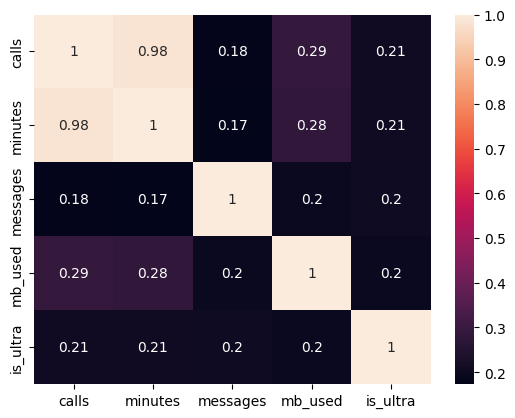

In [18]:
sns.heatmap(data.corr(), annot=True)

As we can see that there is great correlattion between minutes and calls. Lets drop calls from dataset.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good point!

</div>

In [21]:
clean_data = data.drop(['calls'], axis=1)

In [22]:
clean_data.sample(5)

,minutes,messages,mb_used,is_ultra
2593,761.57,0.0,21046.27,0
1628,509.61,4.0,26802.84,0
1007,550.58,25.0,18322.63,0
1754,547.31,58.0,13829.37,0
2532,107.80,0.0,13907.09,0


In [30]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(clean_data)
normalized_data = pd.DataFrame(normalized_data, columns=clean_data.columns)
normalized_data.sample(5)

,minutes,messages,mb_used,is_ultra
1624,0.300712,0.160714,0.410538,0.0
141,0.283145,0.053571,0.376009,0.0
757,0.325527,0.486607,0.391932,1.0
1733,0.289922,0.075893,0.272113,0.0
1282,0.460173,0.200893,0.431601,1.0


<div class="alert alert-warning">
<b>Reviewer's comment</b>

Scaling should be applied after splitting the data into train/validation/test with the scaler fit using the train set to avoid potential data leakage

</div>

# Spliting data into train, validation and test sets

In [122]:
X_train, X_val, X_test, y_train, y_val,  y_test = split_data(clean_data)
X_train_f = pd.concat([X_train, X_val], axis=0) # for final model
y_train_f = pd.concat([y_train, y_val], axis=0) # for final model

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data split is reasonable

</div>

# Decision Tree Classifier

In [123]:
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_model.fit(X_train, y_train)
dtc_predictions = dtc_model.predict(X_val)
dtc_accuracy = accuracy_score(y_val, dtc_predictions)
dtc_accuracy

0.7045101088646968

In [124]:
dtc_model.tree_.max_depth

30

Depth is 30 which is too high.

In [125]:
final_depth = 0
final_score = 0
for depth in range(1, 7):
    dtc_model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    dtc_model.fit(X_train,y_train)
    valid_pred = dtc_model.predict(X_val)
    accuracy = accuracy_score(y_val, valid_pred)
    print("Depth:", depth, "Accuracy:", accuracy)
    if accuracy > final_score:
        final_depth = depth
        final_score = accuracy

print("Final depth =", final_depth,"with training accuracy:",final_score)

Depth: 1 Accuracy: 0.7309486780715396
Depth: 2 Accuracy: 0.7822706065318819
Depth: 3 Accuracy: 0.7916018662519441
Depth: 4 Accuracy: 0.7776049766718507
Depth: 5 Accuracy: 0.7838258164852255
Depth: 6 Accuracy: 0.7884914463452566
Final depth = 3 with training accuracy: 0.7916018662519441


Best depth for deecision tree classifier is 3.

In [126]:
final_dtc_model = DecisionTreeClassifier(random_state=42, max_depth=final_depth)
final_dtc_model.fit(X_train_f, y_train_f)
test_pred = final_dtc_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
final_test_accuracy = {'Decision Tree': test_accuracy}
print("Final test accuracy:", test_accuracy)

Final test accuracy: 0.8055987558320373


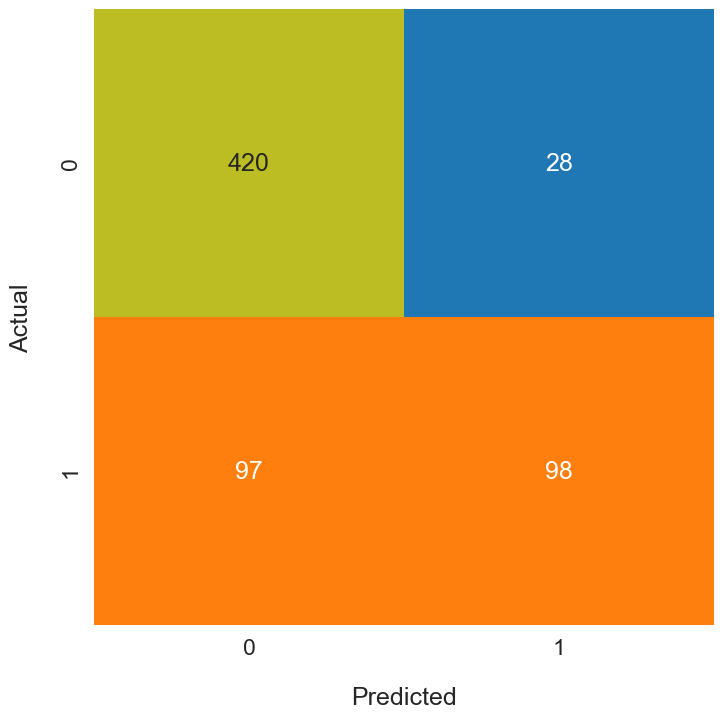

In [127]:
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8,8))

 
ax = sns.heatmap(
    cm, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 
)
 
ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

In [129]:
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)
precision_final = {'Decision Tree': precision}
recall_final = {'Decision Tree': recall}
f1_final = {'Decision Tree': f1}
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.7777777777777778
Recall: 0.5025641025641026
F1 Score: 0.6105919003115264


<div class="alert alert-success">
<b>Reviewer's comment</b>

Good idea to look at the confusion matrix, as well as preicision, recall and F1 score to better understand the model's performance

</div>

# Random Forest

In [130]:
n_estimators = 0
final_score = 0
for i in range(1, 70):
    rfc_model = RandomForestClassifier(n_estimators=i, random_state=42)
    rfc_model.fit(X_train, y_train)
    valid_pred = rfc_model.predict(X_val)
    accuracy = accuracy_score(y_val, valid_pred)
    print("n_estimators:", i, "Accuracy:", accuracy)
    if accuracy > final_score:
        n_estimators = i
        final_score = accuracy


n_estimators: 1 Accuracy: 0.7060653188180405
n_estimators: 2 Accuracy: 0.7589424572317263
n_estimators: 3 Accuracy: 0.7698289269051322
n_estimators: 4 Accuracy: 0.7853810264385692
n_estimators: 5 Accuracy: 0.7651632970451011
n_estimators: 6 Accuracy: 0.7822706065318819
n_estimators: 7 Accuracy: 0.7729393468118196
n_estimators: 8 Accuracy: 0.7853810264385692
n_estimators: 9 Accuracy: 0.7807153965785381
n_estimators: 10 Accuracy: 0.7776049766718507
n_estimators: 11 Accuracy: 0.7744945567651633
n_estimators: 12 Accuracy: 0.7807153965785381
n_estimators: 13 Accuracy: 0.7776049766718507
n_estimators: 14 Accuracy: 0.7838258164852255
n_estimators: 15 Accuracy: 0.7822706065318819
n_estimators: 16 Accuracy: 0.7931570762052877
n_estimators: 17 Accuracy: 0.7931570762052877
n_estimators: 18 Accuracy: 0.7947122861586314
n_estimators: 19 Accuracy: 0.7900466562986003
n_estimators: 20 Accuracy: 0.7978227060653188
n_estimators: 21 Accuracy: 0.80248833592535
n_estimators: 22 Accuracy: 0.8040435458786936

In [131]:

print("Final n_estimators =", n_estimators,"with training accuracy:",final_score)

Final n_estimators = 48 with training accuracy: 0.8055987558320373


Best n_estimators = 22. Now we will find the best max_depth for the Random Forest Classifier

In [132]:
max_depth = 0
final_score = 0
for depth in range(1, 21):
    rfc_model = RandomForestClassifier(n_estimators=48, max_depth=depth, random_state=42)
    rfc_model.fit(X_train, y_train)
    valid_pred = rfc_model.predict(X_val)
    accuracy = accuracy_score(y_val, valid_pred)
    print("max_depth:", depth, "Accuracy:", accuracy)
    if accuracy > final_score:
        max_depth = depth
        final_score = accuracy

max_depth: 1 Accuracy: 0.7309486780715396
max_depth: 2 Accuracy: 0.7807153965785381
max_depth: 3 Accuracy: 0.7807153965785381
max_depth: 4 Accuracy: 0.7838258164852255
max_depth: 5 Accuracy: 0.7884914463452566
max_depth: 6 Accuracy: 0.7900466562986003
max_depth: 7 Accuracy: 0.7931570762052877
max_depth: 8 Accuracy: 0.8009331259720062
max_depth: 9 Accuracy: 0.8009331259720062
max_depth: 10 Accuracy: 0.7993779160186625
max_depth: 11 Accuracy: 0.8087091757387247
max_depth: 12 Accuracy: 0.8040435458786936
max_depth: 13 Accuracy: 0.8055987558320373
max_depth: 14 Accuracy: 0.8040435458786936
max_depth: 15 Accuracy: 0.8118195956454122
max_depth: 16 Accuracy: 0.7947122861586314
max_depth: 17 Accuracy: 0.80248833592535
max_depth: 18 Accuracy: 0.7947122861586314
max_depth: 19 Accuracy: 0.7978227060653188
max_depth: 20 Accuracy: 0.7978227060653188


In [133]:
print("Final max_depth =", max_depth,"with training accuracy:",final_score)

Final max_depth = 15 with training accuracy: 0.8118195956454122


Max depth is 11 for the best accuracy.

In [134]:
final_rnd_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
final_rnd_model.fit(X_train_f, y_train_f)
test_pred = final_rnd_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
final_test_accuracy['Random Forest'] = test_accuracy
print("Final test accuracy:", test_accuracy)

Final test accuracy: 0.8180404354587869


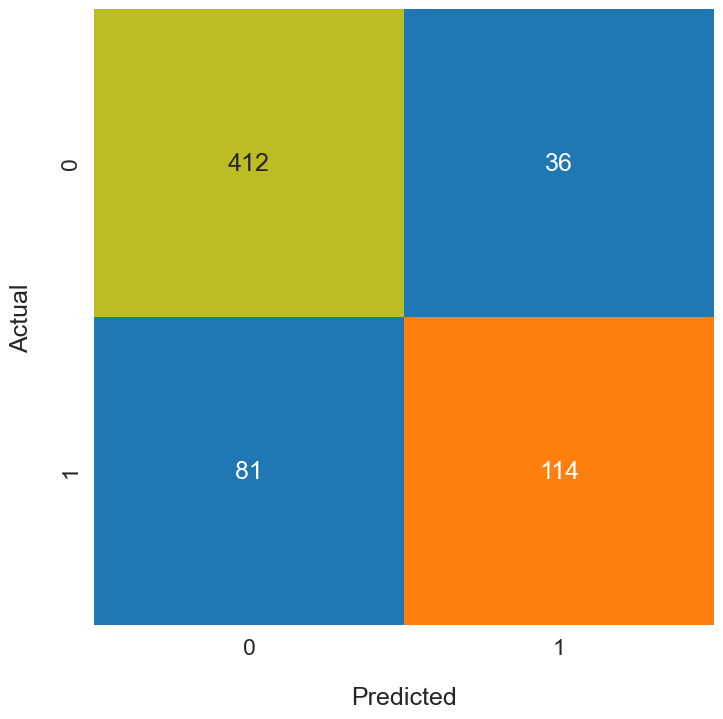

In [135]:
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8,8))

 
ax = sns.heatmap(
    cm, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 
)
 
ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

In [136]:
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)
precision_final['Random Forest'] = precision
recall_final['Random Forest'] = recall
f1_final['Random Forest'] = f1

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.76
Recall: 0.5846153846153846
F1 Score: 0.6608695652173913


# Logistic Regression

In [137]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_val)
lr_accuracy = accuracy_score(y_val, valid_pred)
print("Logistic Regression accuracy:", lr_accuracy)

Logistic Regression accuracy: 0.7978227060653188


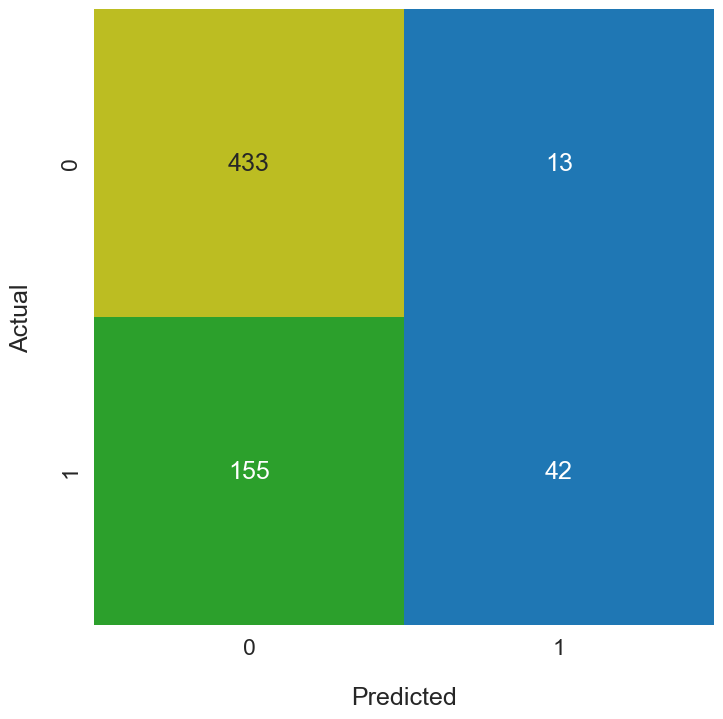

In [138]:
cm = confusion_matrix(y_val, lr_predictions)
plt.figure(figsize=(8,8))

 
ax = sns.heatmap(
    cm, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 
)
 
ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

In [139]:
precision = precision_score(y_val, lr_predictions)
recall = recall_score(y_val, lr_predictions)
f1 = f1_score(y_val, lr_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.7636363636363637
Recall: 0.2131979695431472
F1 Score: 0.3333333333333333


There is a chance that after normalisation score will be higher.

<div class="alert alert-success">
<b>Reviewer's comment</b>

For logistic regression standard scaling might be a better fit than minmax

</div>

In [142]:
X_train_N, X_val_N, X_test_N, y_train_N, y_val_N,  y_test_N = split_data(normalized_data)
X_train_f_N = pd.concat([X_train_N, X_val_N], axis=0) # for final model
y_train_f_N = pd.concat([y_train_N, y_val_N], axis=0) # for final model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_N, y_train_N)
lr_predictions = lr_model.predict(X_val_N)
lr_accuracy = accuracy_score(y_val_N, lr_predictions)
print("Logistic Regression accuracy:", lr_accuracy)

Logistic Regression accuracy: 0.7418351477449455


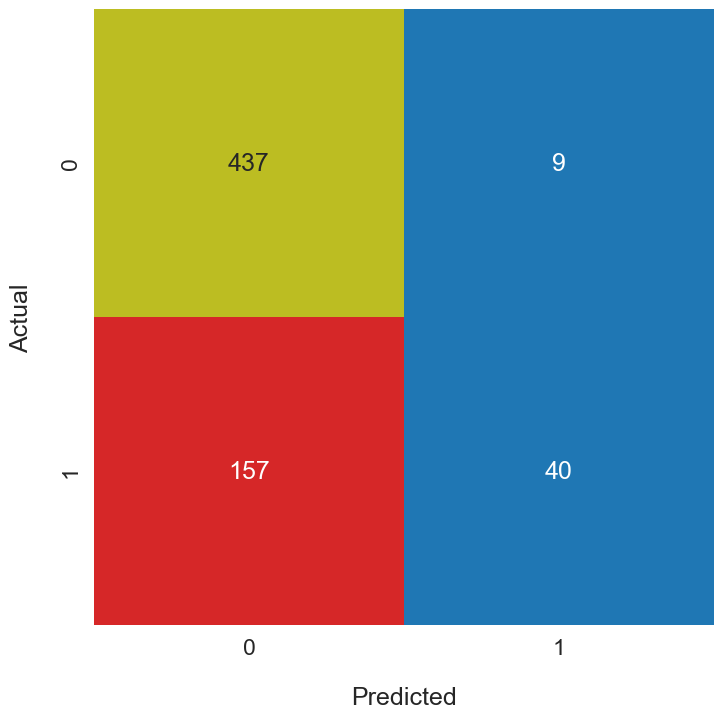

In [143]:
cm = confusion_matrix(y_val, lr_predictions)
plt.figure(figsize=(8,8))

 
ax = sns.heatmap(
    cm, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 
)
 
ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

In [144]:
precision = precision_score(y_val_N, lr_predictions)
recall = recall_score(y_val_N, lr_predictions)
f1 = f1_score(y_val_N, lr_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8163265306122449
Recall: 0.20304568527918782
F1 Score: 0.3252032520325203


In [149]:
lr_model_l1 = LogisticRegression(random_state=42, penalty='l1', solver='liblinear')
lr_model_l1.fit(X_train_N, y_train_N)
lr_predictions = lr_model_l1.predict(X_val_N)
lr_accuracy = accuracy_score(y_val_N, lr_predictions)
print("Logistic Regression L1 accuracy:", lr_accuracy)

Logistic Regression L1 accuracy: 0.7418351477449455


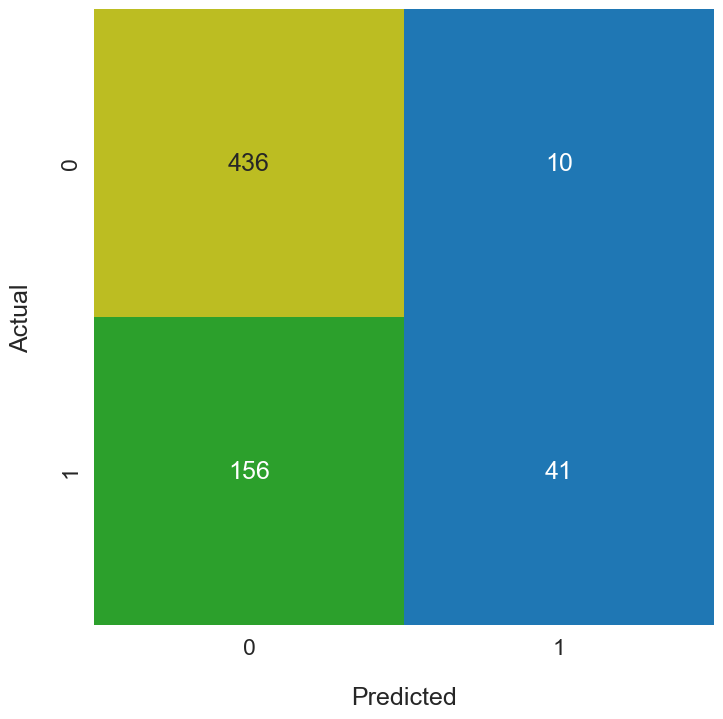

In [146]:
cm = confusion_matrix(y_val, lr_predictions)
plt.figure(figsize=(8,8))

ax = sns.heatmap(
    cm, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

In [147]:
precision = precision_score(y_val_N, lr_predictions)
recall = recall_score(y_val_N, lr_predictions)
f1 = f1_score(y_val_N, lr_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.803921568627451
Recall: 0.20812182741116753
F1 Score: 0.33064516129032256


In [150]:
lr_model_2 = LogisticRegression(random_state=42, C=0.1)
lr_model_2.fit(X_train_N, y_train_N)
lr_predictions = lr_model_2.predict(X_val_N)
lr_accuracy = accuracy_score(y_val_N, lr_predictions)
print("Logistic Regression accuracy:", lr_accuracy)

Logistic Regression accuracy: 0.7169517884914464


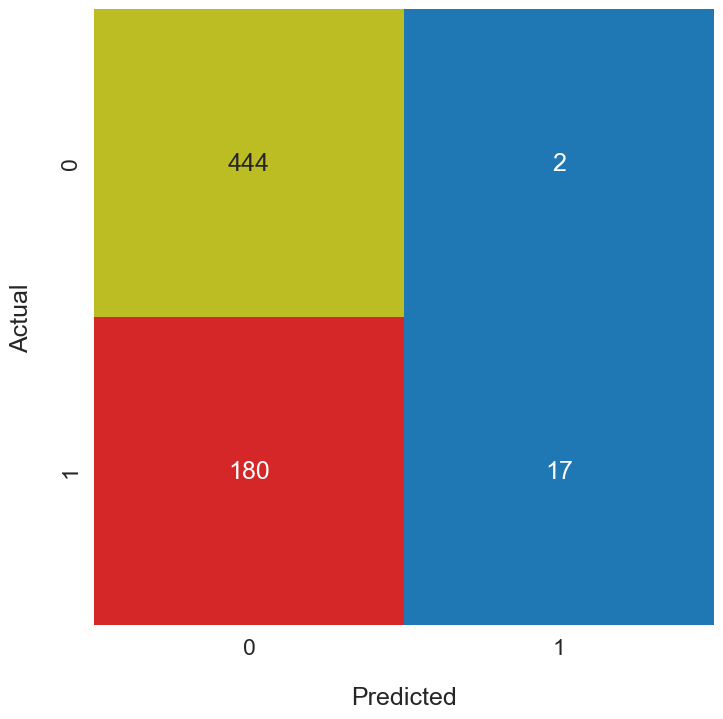

In [151]:
cm = confusion_matrix(y_val, lr_predictions)
plt.figure(figsize=(8,8))

ax = sns.heatmap(
    cm, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

In [153]:
C_values = [0.01, 0.1, 1, 10, 100]

for c in C_values:
    lr_model = LogisticRegression(random_state=42, C=c)
    lr_model.fit(X_train_N, y_train_N)
    lr_predictions = lr_model.predict(X_val_N)
    lr_accuracy = accuracy_score(y_val_N, lr_predictions)
    print("C:", c, "Accuracy:", lr_accuracy)
    print("Precision:", precision_score(y_val_N, lr_predictions))
    print("Recall:", recall_score(y_val_N, lr_predictions))
    print("F1 Score:", f1_score(y_val_N, lr_predictions))

C: 0.01 Accuracy: 0.6936236391912908
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
C: 0.1 Accuracy: 0.7169517884914464
Precision: 0.8947368421052632
Recall: 0.08629441624365482
F1 Score: 0.1574074074074074
C: 1 Accuracy: 0.7418351477449455
Precision: 0.8163265306122449
Recall: 0.20304568527918782
F1 Score: 0.3252032520325203
C: 10 Accuracy: 0.7402799377916018
Precision: 0.7777777777777778
Recall: 0.2131979695431472
F1 Score: 0.3346613545816733
C: 100 Accuracy: 0.7402799377916018
Precision: 0.7777777777777778
Recall: 0.2131979695431472
F1 Score: 0.3346613545816733


/Users/alexander/Desktop/ML/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters for the logistic regression model are not clear if we are using not only accuracy score but also precision, recall and f1 score. It is better to use the default parameters for the logistic regression model. Also without normalisation.

In [155]:
final_lr_model = LogisticRegression(random_state=42)
final_lr_model.fit(X_train_f, y_train_f)
lr_prerdiction = final_lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_prerdiction)
final_test_accuracy['Logistic Regression'] = lr_accuracy
print("Final test accuracy:", lr_accuracy)

Final test accuracy: 0.7636080870917574


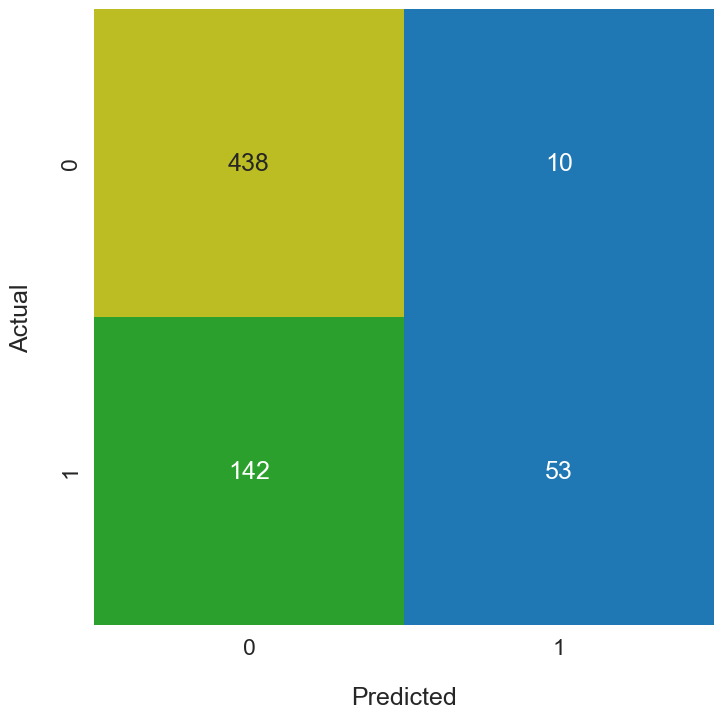

In [156]:
cm = confusion_matrix(y_test, lr_prerdiction)
plt.figure(figsize=(8,8))

ax = sns.heatmap(
    cm, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

In [157]:
precision = precision_score(y_test, lr_prerdiction)
recall = recall_score(y_test, lr_prerdiction)
f1 = f1_score(y_test, lr_prerdiction)
precision_final['Logistic Regression'] = precision
recall_final['Logistic Regression'] = recall
f1_final['Logistic Regression'] = f1

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8412698412698413
Recall: 0.2717948717948718
F1 Score: 0.4108527131782946


<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you tried a few different models, tuned their hyperparameters using the validation set and evaluated the final models using the test set

</div>

# Final results and conclusions

In [159]:
data = [
    {'Decision Tree': 0.8055987558320373, 'Random Forest': 0.8180404354587869, 'Logistic Regression': 0.7636080870917574},
    {'Decision Tree': 0.7777777777777778, 'Random Forest': 0.76, 'Logistic Regression': 0.8412698412698413},
    {'Decision Tree': 0.5025641025641026, 'Random Forest': 0.5846153846153846, 'Logistic Regression': 0.2717948717948718},
    {'Decision Tree': 0.6105919003115264, 'Random Forest': 0.6608695652173913, 'Logistic Regression': 0.4108527131782946}
]
scores = pd.DataFrame(data, index=['Accuracy', 'Precision', 'Recall', 'F1'])
display(scores)

,Decision Tree,Random Forest,Logistic Regression
Accuracy,0.805599,0.818040,0.763608
Precision,0.777778,0.760000,0.841270
Recall,0.502564,0.584615,0.271795
F1,0.610592,0.660870,0.410853


This project successfully developed Decision Tree, Random Forest classification  and Logistic regression models all achieving an accuracy above 0.75, exceeding the target threshold.  Hyperparameter tuning was critical in optimizing models performance. Best in accuracy, recall and in F1 score is Random Forest. Log regrression is good only in precision. Decision Tree is somewhere in the middle. But after considiration of all scoring in my oppinion the best model is random forest classifier. Deployment of this model will directly empower Megaline to provide targeted plan upgrades.


<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent!

</div>